<a href="https://colab.research.google.com/github/Macha1804/More-Time/blob/main/UNet_2D_IRM_TUMORS_RESTITUTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing librairies and packages

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import re
import pickle

import cv2
from PIL import Image
from scipy.ndimage import gaussian_filter

import matplotlib.pyplot as plt
import IPython.display as display
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras import optimizers,\
                             metrics, \
                             losses, \
                             backend

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from sklearn.model_selection import train_test_split



In [ ]:
tf.__version__

'2.8.2'

In [ ]:
#Installing TFA to apply the gaussian filter
!pip install tensorflow-addons
import tensorflow_addons as tfa
from tensorflow_addons import image
from tensorflow_addons.image import gaussian_filter2d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Mounting GCS Buckets

In [ ]:
#mount bucket
from google.colab import auth
auth.authenticate_user()

project_id = 'more-time-812'
!gcloud config set project {project_id}

Updated property [core/project].


In [ ]:
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0   145k      0 --:--:-- --:--:-- --:--:--  145k
OK
57 packages can be upgraded. Run 'apt list --upgradable' to see them.
gcsfuse is already the newest version (0.41.4).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 57 not upgraded.


In [ ]:
!mkdir more-time
!gcsfuse --implicit-dirs more-time more-time

mkdir: cannot create directory ‘more-time’: File exists
2022/06/27 18:00:53.007895 Start gcsfuse/0.41.4 (Go version go1.17.6) for app "" using mount point: /content/more-time
2022/06/27 18:00:53.022130 Opening GCS connection...
2022/06/27 18:00:53.174235 Mounting file system "more-time"...
2022/06/27 18:00:53.175970 File system has been successfully mounted.


### Choose a root-path: either local, GDrive or GCS

In [ ]:
ROOT_PATH = 'more-time'

### IMPORTING DATASET

In [ ]:
PICKLE_ROOT_PATH = ROOT_PATH + '/Data/pickles/UNet2D/'

In [ ]:
with open(PICKLE_ROOT_PATH + 'X_test.pkl', 'rb') as f:
  X_test = pickle.load(f)

with open(PICKLE_ROOT_PATH + 'y_test.pkl', 'rb') as f:
  y_test = pickle.load(f)

# Data pre-processing

In [ ]:
#Adding to the black and white masks a dimension 
y_test = y_test.reshape((X_test.shape[0], 256, 256, 1))
print(y_test.shape)

(440, 256, 256, 1)


In [ ]:
#Padding X
pad=pad_sequences(X_test)

# Defining the metrics and losses


In [ ]:
SMOOTH = .001
def compute_basics(y_true, y_pred):

  intersection = np.sum(np.abs(y_pred * y_true)) 
  mask_sum = np.sum(np.abs(y_true)) + np.sum(np.abs(y_pred))
  union = mask_sum - intersection

  return intersection, mask_sum, union


In [ ]:
def dice_metrics(y_pred, y_true, k = 1):
  # first check that both masks and predictions are actually empty
  # if so, return 1 
  m_, p_ = y_true, y_pred

  if np.sum(m_[m_==k]) == np.sum(p_[p_==k]) and \
      np.sum(m_[m_==k]) == 0:
      return 1

  intersection, mask_sum, union = compute_basics(m_, p_)  
  return 2*(intersection + SMOOTH)/(mask_sum + SMOOTH)

In [ ]:
def IoU_metrics(y_true, y_pred, k = 1):
  
  m_, p_ = y_true, y_pred
  
  if np.sum(m_[m_==k]) == np.sum(p_[p_==k]) and \
      np.sum(m_[m_==k]) == 0:
      return 1

  intersection, mask_sum , union = compute_basics(m_, p_)
  return  (intersection + SMOOTH) / (union + SMOOTH)


In [ ]:
def dice_metrics_tf(y_true,y_pred, smooth=.001):

    y_true_f = tf.reshape(y_true,[-1])
    y_pred_f = tf.reshape(y_pred,[-1])

    intersection = tf.math.reduce_sum(tf.math.abs(y_true_f * y_pred_f))
    mask_sum =  tf.math.reduce_sum(tf.math.abs(y_true_f)) + tf.math.reduce_sum(tf.math.abs(y_pred_f))
    return (2. * intersection + smooth) / (mask_sum + smooth)


def dice_loss_tf(y_true,y_pred, smooth=.001):

    y_true_f = tf.cast(tf.reshape(y_true,[-1]),tf.float32)
    y_pred_f =tf.cast(tf.reshape(y_pred,[-1]),tf.float32)

    intersection = tf.reduce_sum(tf.math.abs(y_true_f * y_pred_f))
    mask_sum =  tf.math.reduce_sum(tf.math.abs(y_true_f)) + tf.math.reduce_sum(tf.math.abs(y_pred_f))
    return (1-(2. * intersection + smooth) / (mask_sum + smooth))

In [ ]:
def IoU_metrics_tf(y_true,y_pred, smooth=.001):

    y_true_f = tf.reshape(y_true,[-1])
    y_pred_f = tf.reshape(y_pred,[-1])

    intersection = tf.math.reduce_sum(tf.math.abs(y_true_f * y_pred_f))
    mask_sum =  tf.math.reduce_sum(tf.math.abs(y_true_f)) + tf.math.reduce_sum(tf.math.abs(y_pred_f))
    union = mask_sum - intersection
    return (intersection + smooth) / (union + smooth)


def IoU_loss_tf(y_true,y_pred, smooth=.001):

    y_true_f = tf.cast(tf.reshape(y_true,[-1]),tf.float32)
    y_pred_f =tf.cast(tf.reshape(y_pred,[-1]),tf.float32)

    intersection = tf.reduce_sum(tf.math.abs(y_true_f * y_pred_f))
    mask_sum =  tf.math.reduce_sum(tf.math.abs(y_true_f)) + tf.math.reduce_sum(tf.math.abs(y_pred_f))
    union = mask_sum - intersection
    return (1-(intersection + smooth) / (union + smooth))

# Loading UNet and perform prediction

In [ ]:
from tensorflow import keras
model = keras.models.load_model(ROOT_PATH + '/Model/UNet_2D/UNet_augmented-do-0.2.h5',
                                custom_objects={"IoU_metrics_tf": IoU_metrics_tf,
                                                "dice_metrics_tf": dice_metrics_tf})

In [ ]:
#Define the prediction and plotting functions
def predict (valMap, model, shape = 256):
    ## getting and proccessing val data
    test_shape = y_test.shape[0]
    img = valMap['img'][0:test_shape]
    mask = valMap['mask'][0:test_shape]
    
    imgProc = img [0:test_shape]
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
    
    return predictions, imgProc, mask

def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(9,9))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('IRM slice')
    
    plt.subplot(1,3,2)
    plt.imshow(predMask, cmap='viridis')
    plt.title('Predicted segmentation')
    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth, cmap='viridis')
    plt.title('Actual segmentation')

In [ ]:
#Creating a dictionnary with the test satellite images and masks
test_shape = y_test.shape[0]
TestObj = {'img':np.array(X_test), 'mask':np.array(y_test).reshape(test_shape, 256, 256)}
predict, actuals, masks = predict(TestObj, model)

In [ ]:
predict.shape

(440, 256, 256, 1)

In [ ]:
masks.shape

(440, 256, 256)

In [ ]:
SAMPLE = 201

In [ ]:
print(np.max(predict[SAMPLE][:,:,0]))
print(np.min(predict[SAMPLE][:,:,0]))

0.9996817
4.034514e-08


In [ ]:
print(np.max(masks[SAMPLE][:,:]))
print(np.min(masks[SAMPLE][:,:]))

1
0


In [ ]:
# playground before engineering
p_ = predict[SAMPLE]
m_ = masks[SAMPLE]
x_ = actuals[SAMPLE]
print(x_.shape)
print(p_.shape)
print(m_.shape)

(256, 256, 3)
(256, 256, 1)
(256, 256)


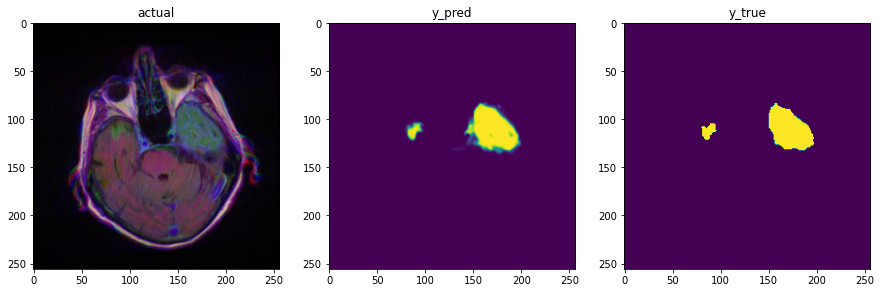

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (15,5))

ax[0].imshow(x_)
ax[0].set_title('actual')
ax[1].imshow(p_.reshape(p_.shape[0:2]), cmap = 'viridis')
ax[1].set_title('y_pred')
ax[2].imshow(m_, cmap = 'viridis')
ax[2].set_title('y_true');



In [ ]:
th_ = 0.7
p__ = np.where(p_ < th_, 0,1)
print(np.max(p__))
print(np.min(p__))
print(np.max(m_))
print(np.min(m_))

1
0
1
0


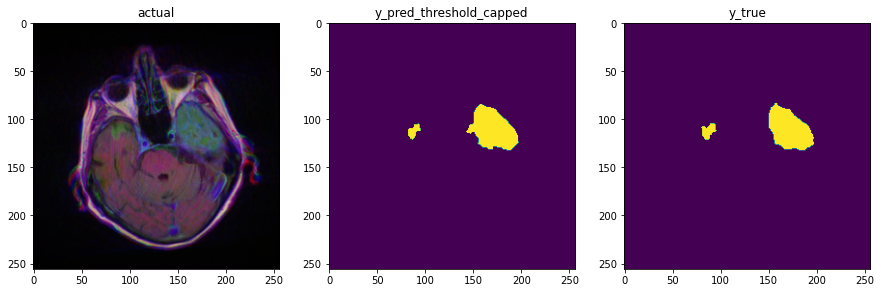

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (15,5))
ax[0].imshow(x_)
ax[0].set_title('actual')
ax[1].imshow(p__.reshape(p__.shape[0:2]), cmap = 'viridis')
ax[1].set_title('y_pred_threshold_capped')
ax[2].imshow(m_, cmap = 'viridis')
ax[2].set_title('y_true');

In [ ]:
def contour_to_list(contour):
    l = [dots.tolist()[0] for dots in contour]
    xs, ys = zip(*l)
    return xs, ys

In [ ]:
def compute_roi(contour:list):
    xs, ys = contour_to_list(contour)
    return np.min(xs), np.min(ys), np.max(xs), np.max(ys)

In [ ]:
# identify the biggest contour => find the biggest ROI!
# *BUT* exclude contour of image itself
def get_brain_contour(img):
    
    # compute maximum area
    max_area = img.shape[0] * img.shape[1]
    
    ret, thresh = cv2.threshold(img, 12, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    areas = []

    for c in contours:        
        # retrieve bounding box
        left, bottom, right, top = compute_roi(c)
        
        #compute ROI area=> the biggest wins
        area = (right-left) * (top-bottom)
        if area < max_area:
            areas.append(area)

    brain_contour = contours[np.argmax(areas, axis=0)]  
    np.append(brain_contour, brain_contour[0])
    return brain_contour

In [ ]:
def t_contour(img):
    ret, thresh = cv2.threshold(img, 22, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours

In [ ]:
# counting anomalies
m__ = m_.astype(np.uint8)
m__ = np.where(m__ < 1, 0, 255)
m__ = cv2.normalize(src=m__, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)

anomalies_true = t_contour(m__)
print(f"number of anomalies in y_true: {len(anomalies_true)}")

number of anomalies in y_true: 2


In [ ]:
# counting anomalies
p3__ = p__.reshape(p__.shape[0:2]).astype(np.uint8)
p3__ = np.where(p3__ < 1, 0, 255)
p3__ = cv2.normalize(src=p3__, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)

anomalies_pred = t_contour(p3__)
print(f"number of anomalies in y_pred: {len(anomalies_pred)}")

number of anomalies in y_pred: 2


In [ ]:
def find_area(array):
    a = 0
    ox,oy = array[0]
    for x,y in array[1:]:
        a += (x*oy-y*ox)
        ox,oy = x,y
    return a/2

In [ ]:
# compute brain area
x__ = x_.astype(np.uint8)
im_cv2_gray= cv2.cvtColor(x__, cv2.COLOR_RGB2GRAY)
brain_contour = get_brain_contour(im_cv2_gray)
brain_area = find_area(brain_contour[:,0,:])

# compute areas for predicted anomalies 
predicted_areas = []
for a in anomalies_pred:
  area = find_area(a[:,0,:])
  if area > 0:
    predicted_areas.append((area, round(area/brain_area * 100, 2)))

# compute areas for true anomalies
actual_areas = []
for a in anomalies_true:
  area = find_area(a[:,0,:])
  actual_areas.append((area, round(area/brain_area * 100, 2)))

In [ ]:
print(predicted_areas)
print(actual_areas)

[(105.5, 0.38), (1606.5, 5.71)]
[(347.0, 1.23), (1528.0, 5.43)]


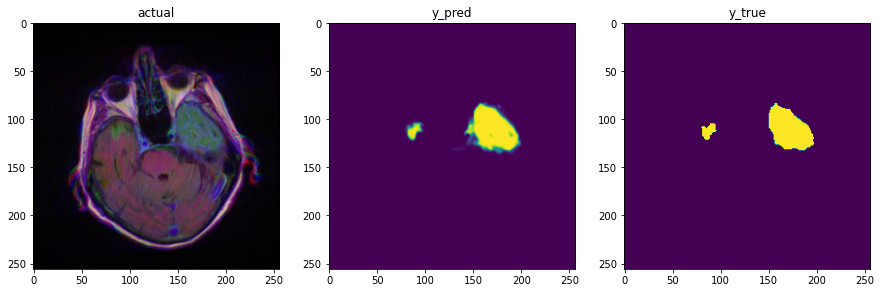

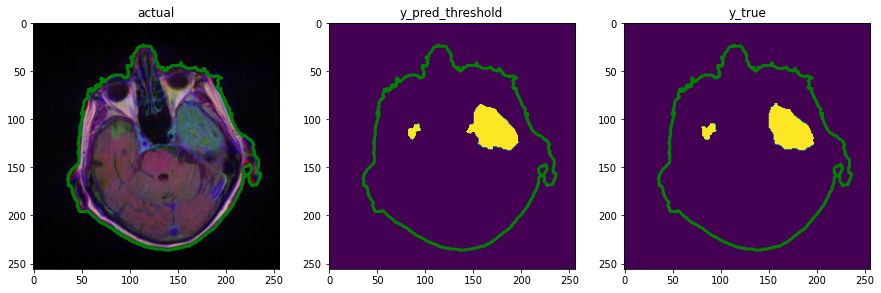

_________________________

computed probabilty: 93.55%

_________________________

predicted anomalies count: 2
..... predicted anomaly n°1 = 0.38 % of brain tissue in MRI slice
..... predicted anomaly n°2 = 5.71 % of brain tissue in MRI slice

actual anomalies count: 2
..... actual anomaly n°1 = 1.23 % of brain tissue in MRI slice
..... actual anomaly n°2 = 5.43 % of brain tissue in MRI slice
_________________________


In [ ]:
# convert np.array to image
x__ = x_.astype(np.uint8)
im_cv2_gray= cv2.cvtColor(x__, cv2.COLOR_RGB2GRAY)
# compute contours
brain_contour = get_brain_contour(im_cv2_gray)
xs, ys = contour_to_list(brain_contour)
# display
fig, ax = plt.subplots(1, 3, figsize = (15,5))

ax[0].imshow(x_)
ax[0].set_title('actual')
ax[1].imshow(p_.reshape(p_.shape[0:2]), cmap = 'viridis')
ax[1].set_title('y_pred')
ax[2].imshow(m_, cmap = 'viridis')
ax[2].set_title('y_true');

fig, ax = plt.subplots(1, 3, figsize = (15,5))
ax[0].imshow(x_, cmap = 'gray')
ax[0].plot(xs,ys,'g', linewidth=3.0)
ax[0].set_title('actual')

ax[1].imshow(p__.reshape(p__.shape[0:2]), cmap = 'viridis')
ax[1].plot(xs,ys,'g', linewidth=3.0)
ax[1].set_title('y_pred_threshold')

ax[2].imshow(m_, cmap = 'viridis')
ax[2].plot(xs,ys,'g', linewidth=3.0)
ax[2].set_title('y_true');
plt.show()


# compute average proba above threshold
th_ = 0.5
proba = p_[p_>th_].mean()

print('_________________________')
print('')
print(f"Average probability of tumor for yellow-highlighted area: {round(proba * 100, 2)}%")
print('')
print('_________________________')
print('')
print(f"predicted anomalies count: {len(predicted_areas)}")
for i, t in enumerate(predicted_areas):
  print(f'..... predicted anomaly n°{i+1} = {t[1]} % of brain tissue in MRI slice')
print('')
print(f"actual anomalies count: {len(actual_areas)}")
for i, t in enumerate(actual_areas):
  print(f'..... actual anomaly n°{i+1} = {t[1]} % of brain tissue in MRI slice')
print('_________________________')


In [ ]:
SAMPLE = 255

In [ ]:
print(np.max(predict[SAMPLE][:,:,0]))
print(np.min(predict[SAMPLE][:,:,0]))

p_ = predict[SAMPLE]
m_ = masks[SAMPLE]
x_ = actuals[SAMPLE]

0.035086274
1.5844671e-09


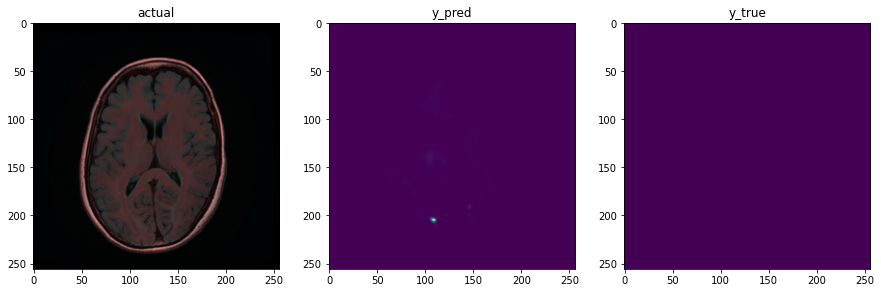

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (15,5))

ax[0].imshow(x_)
ax[0].set_title('actual')
ax[1].imshow(p_.reshape(p_.shape[0:2]), cmap = 'viridis')
ax[1].set_title('y_pred')
ax[2].imshow(m_, cmap = 'viridis')
ax[2].set_title('y_true');

In [ ]:
# counting anomalies
m__ = m_.astype(np.uint8)
m__ = np.where(m__ < 1, 0, 255)
m__ = cv2.normalize(src=m__, 
                    dst=None, 
                    alpha=0, beta=255, 
                    norm_type=cv2.NORM_MINMAX,
                    dtype=cv2.CV_8UC1)

anomalies_true = t_contour(m__)
print(f"number of anomalies in y_true: {len(anomalies_true)}")

number of anomalies in y_true: 0


In [ ]:
# counting anomalies
p3__ = p__.reshape(p__.shape[0:2]).astype(np.uint8)
p3__ = np.where(p3__ < 1, 0, 255)
p3__ = cv2.normalize(src=p3__, 
                     dst=None, 
                     alpha=0, beta=255, 
                     norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)

anomalies_pred = t_contour(p3__)
print(f"number of anomalies in y_pred: {len(anomalies_pred)}")

number of anomalies in y_pred: 0


In [ ]:
# compute brain area
x__ = x_.astype(np.uint8)
im_cv2_gray= cv2.cvtColor(x__, cv2.COLOR_RGB2GRAY)
brain_contour = get_brain_contour(im_cv2_gray)
brain_area = find_area(brain_contour[:,0,:])

# compute areas for predicted anomalies 
predicted_areas = []
for a in anomalies_pred:
  area = find_area(a[:,0,:])
  if area > 0:
    predicted_areas.append((area, round(area/brain_area * 100, 2)))

# compute areas for true anomalies
actual_areas = []
for a in anomalies_true:
  area = find_area(a[:,0,:])
  actual_areas.append((area, round(area/brain_area * 100, 2)))

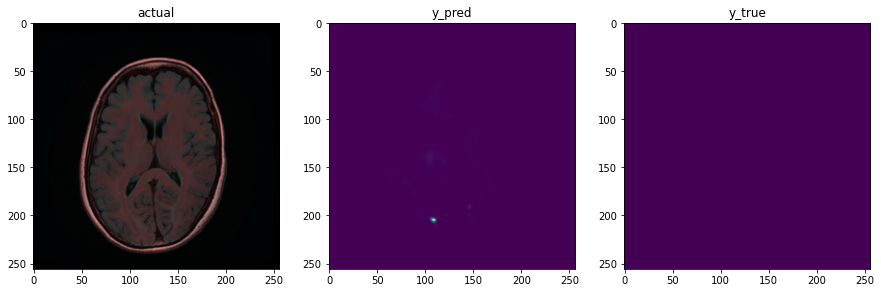

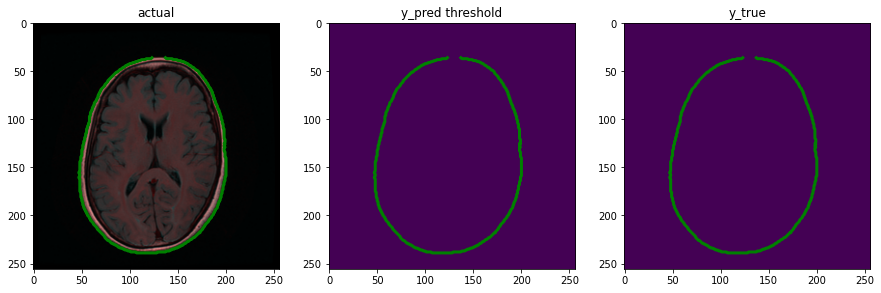

_________________________

computed probabilty: 99.99684%

_________________________

predicted anomalies count: 0

actual anomalies count: 0
_________________________


In [ ]:
th_ = 0.7
p__ = np.where(p_ < th_, 0,1)

# convert np.array to image
x__ = x_.astype(np.uint8)
im_cv2_gray= cv2.cvtColor(x__, cv2.COLOR_RGB2GRAY)
# compute contours
brain_contour = get_brain_contour(im_cv2_gray)
xs, ys = contour_to_list(brain_contour)

# compute average proba above threshold
th_ = 0.5
proba = 1 - p_[p_<th_].mean()

# display
fig, ax = plt.subplots(1, 3, figsize = (15,5))
ax[0].imshow(x_)
ax[0].set_title('actual')
ax[1].imshow(p_.reshape(p_.shape[0:2]), cmap = 'viridis')
ax[1].set_title('y_pred')
ax[2].imshow(m_, cmap = 'viridis')
ax[2].set_title('y_true');

fig, ax = plt.subplots(1, 3, figsize = (15,5))
ax[0].imshow(x_)
ax[0].plot(xs,ys,'g', linewidth=3.0)
ax[0].set_title('actual')
ax[1].imshow(p__.reshape(p__.shape[0:2]), cmap = 'viridis')
ax[1].plot(xs,ys,'g', linewidth=3.0)
ax[1].set_title('y_pred threshold')
ax[2].imshow(m_, cmap = 'viridis')
ax[2].plot(xs,ys,'g', linewidth=3.0)
ax[2].set_title('y_true');
plt.show();

print('_________________________')
print('')
print(f"computed probabilty: {round(proba * 100, 5)}%")
print('')
print('_________________________')
print('')
print(f"predicted anomalies count: {len(predicted_areas)}")
for i, t in enumerate(predicted_areas):
  print(f'..... predicted anomaly n°{i+1} = {t[1]} % of brain tissue in MRI slice')
print('')
print(f"actual anomalies count: {len(actual_areas)}")
for i, t in enumerate(actual_areas):
  print(f'..... actual anomaly n°{i+1} = {t[1]} % of brain tissue in MRI slice')
print('_________________________')